In [7]:
from mGST import compatibility,algorithm, optimization, low_level_jit, additional_fns
from mGST.reporting import uncertainty, reporting

from argparse import Namespace
from pandas import read_csv
from exp_design.target_gates import *
import pickle

In [8]:
folder_name = "exp_data"
basis_dict = {'00':0, '01':0, '10':1, '11':1}

In [9]:
# Import sequence list
J_list = read_csv("exp_design/sequences.csv", delimiter=",", names = list(range(32))).values
N = J_list.shape[0] + 1
J_list = [[int(x) for x in J_list[i,:] if str(x) != 'nan'] for i in range(N-1)]
J_list.insert(0,[])
l_max = np.max([len(J_list[i]) for i in range(N)])

J = []
for i in range(N):
    J.append(list(np.pad(J_list[i],(0,l_max-len(J_list[i])),'constant',constant_values=-1)))
J = np.array(J).astype(int)[:,::-1]

In [10]:
y, meas_samples = reporting.outcome_probs_from_files(folder_name, basis_dict, n_povm,N)

Starting optimization...
100%|█████████████████████████████████████████████| 2/2 [00:08<00:00,  4.32s/it]


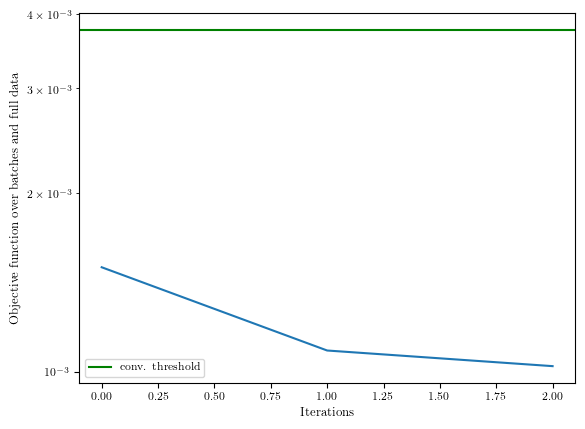

#################
	 Convergence criterion satisfied
	 Final objective function value 0.0010214609545433646 with # of initializations: 1 
 	 Total runtime: 10.259578227996826


In [11]:
mGST_args = {'y': y, 'J': J, 'l': l_max, 'd': d, 'r': r, 'rK': rK, 'n_povm': n_povm, 'bsize': bsize, 
             'meas_samples': meas_samples, 'method': 'SFN', 'max_inits': 10, 'max_iter': 100, 
             'final_iter': 2, 'threshold_multiplier': 5, 'target_rel_prec': 5e-6}
ns = Namespace(**mGST_args)

K_target = additional_fns.Kraus_rep(X_target,d,pdim,rK)

if from_init:
    K,X,E,rho,res_list = algorithm.run_mGST(ns.y,ns.J,ns.l,ns.d,ns.r,ns.rK, ns.n_povm, ns.bsize, ns.meas_samples, method = ns.method,
                     max_inits = ns.max_inits, max_iter = 0, final_iter = ns.final_iter, threshold_multiplier = ns.threshold_multiplier, 
                     target_rel_prec = ns.target_rel_prec, init = [K_target, E_target, rho_target], testing = True)   
else:
    K,X,E,rho,res_list = algorithm.run_mGST(ns.y,ns.J,ns.l,ns.d,ns.r,ns.rK, ns.n_povm, ns.bsize, ns.meas_samples, method = ns.method,
                     max_inits = ns.max_inits, max_iter = ns.max_iter, final_iter = ns.final_iter, threshold_multiplier = ns.threshold_multiplier, 
                     target_rel_prec = ns.target_rel_prec, testing = True)   

In [13]:
# aim: show preliminary results in console and ask if report should be generated & Ask for bootstrapping
target_mdl = compatibility.arrays_to_pygsti_model(X_target,E_target,rho_target, basis = 'std')

weights = {'G0': 1,'G1': 1, 'G2': 1, 'G3': 1, 'G4': 1, 'G5': 1, 'spam': 1}
gate_labels = {0: "Idle_short", 1: "Idle_long", 2: "Rx(pi)", 3: "Ry(pi)", 4: "Rx(pi/2)", 5: "Ry(pi/2)"}
X_opt, E_opt, rho_opt = reporting.gauge_opt(X, E, rho, target_mdl, weights)
f_g, df_o, s_g, s_o = reporting.quick_report(X_opt, E_opt, rho_opt, J, y, target_mdl, gate_labels)

display(s_g), display(s_o)  

,F_avg,Min. Spectral distances
Idle_short,"0,99975","0,01565"
Idle_long,"0,99961","0,00950"
Rx(pi),"0,99951","0,00717"
Ry(pi),"0,99976","0,00168"
Rx(pi/2),"0,99847","0,01770"
Ry(pi/2),"0,99965","0,00577"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,State - Trace dist.
,0.001021,0.025782,0.030960,0.006192


(None, None)

In [23]:
print(f_g.to_string())

               F_avg  Min. Spectral distances
Idle_short  0.999754                 0.015654
Idle_long   0.999613                 0.009501
Rx(pi)      0.999507                 0.007173
Ry(pi)      0.999757                 0.001681
Rx(pi/2)    0.998471                 0.017704
Ry(pi/2)    0.999648                 0.005767


In [37]:
# ###################################### 
experiment_name = 'test'
bootstrapping = False
filename = 'mgst_results/results_'+experiment_name

if bootstrapping:
    results = {'estimates': (K,X,E,rho), 'gauge_opt_estimates': (X_opt, E_opt, rho_opt), 'bootstrap_data': (X_array, E_array, rho_array, df_g_array, df_o_array)}
else:
    results = {'estimates': (K,X,E,rho), 'gauge_opt_estimates': (X_opt, E_opt, rho_opt)}
data_to_safe = {'parameters': mGST_args, 'results': results}

with open(filename, 'wb') as handle:
    pickle.dump(data_to_safe, handle, protocol=pickle.HIGHEST_PROTOCOL)

NameError: name 'pickle' is not defined